# Load data

In [1]:
import sys
import os
sys.path.append("/home/sina/env_prediction_project/Trajectron-plus-plus/trajectron")
sys.path.append("/home/sina/env_prediction_project/Trajectron-plus-plus/experiments/pedestrians")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import dill as pickle
from evaluate import load_model
from trajectron import evaluation
from tqdm import tqdm
import csv

In [2]:
# Path to data and models

# Model with dynamics
model_path = "/home/sina/env_prediction_project/Trajectron-plus-plus/experiments/pedestrians/models/models_12_Mar_2025_16_09_04_eth_ar3"
model_name = "models_12_Mar_2025_16_09_04_eth_ar3"
# ## Model without dynamics
# model_path = "/home/sina/env_prediction_project/Trajectron-plus-plus/experiments/pedestrians/models/models_12_Mar_2025_23_52_57_eth_vel_ar3"
# model_path = "/home/sina/env_prediction_project/Trajectron-plus-plus/experiments/pedestrians/models/eth_attention_radius_3"
# model_name = "eth_attention_radius_3"
# model_path = "/home/sina/env_prediction_project/Trajectron-plus-plus/experiments/pedestrians/models/eth_vel"
# model_name = "eth_vel"

data_path = '/home/sina/env_prediction_project/Trajectron-plus-plus/experiments/processed/'

In [3]:
# SELECT DATASET
dataset = 'univ_test'

# Load environment (processed dataset)
with open(f"{data_path}/{dataset}.pkl", "rb") as file:
    env = pickle.load(file, encoding='latin1')

print("Scenes in the environment:", env.scenes)

# # Print the attributes of the env object
# for attribute in dir(env):
#     if not attribute.startswith('__'):
#         print(attribute)
#         try:
#             value = getattr(env, attribute)
#             print(f"{attribute}: {value}")
#         except:
#             None

Scenes in the environment: [Scene: Duration: 216.4s, Nodes: 434, Map: No., Scene: Duration: 177.60000000000002s, Nodes: 415, Map: No.]


In [4]:
# SELECT PEDESTRIAN
ped_id = 0 # ID 0 means the pedestrian with the longest trajectory

# Select the n_th pedestrian with the longest trajectory
n_long = 2
scene_id = 0

# Get the desired scene
scene = env.scenes[scene_id]
print(f"Scene has {scene.timesteps} timesteps.")

# Get the timesteps of the scene
timesteps = np.arange(scene.timesteps)

# Get all pedestrians in the scene
pedestrian_nodes = [node for node in scene.nodes if node.type.name == "PEDESTRIAN"]
print(f"Scene has {len(pedestrian_nodes)} pedestrians nodes.")

# Select the pedestrian
if ped_id == 0:
    sorted_pedestrians = sorted(pedestrian_nodes, key=lambda ped: ped.last_timestep - ped.first_timestep + 1, reverse=True)
    # Select the n_th pedestrian with the longest trajectory
    target_pedestrian = sorted_pedestrians[n_long] if len(sorted_pedestrians) > 0 else None
    print(f"Pedestrian with n_th Longest Trajectory: {target_pedestrian}, {target_pedestrian.last_timestep - target_pedestrian.first_timestep+1} timesteps")
else:
    target_pedestrian = next(ped for ped in pedestrian_nodes if ped.id == str(ped_id))
    print(f"Selected Pedestrian ID: {target_pedestrian.id}")

Scene has 541 timesteps.
Scene has 434 pedestrians nodes.
Pedestrian with n_th Longest Trajectory: PEDESTRIAN/376, 230 timesteps


In [5]:
# Get the ground truth data for the pedestrian

# Load ground truth trajectory
ground_truth = []

# Define the state type
state_key = 'position'

print(f"Using state key: {state_key}")

with open(f"{model_path}/config.json", 'r') as config_file:
    hyperparams = json.load(config_file)

t0_ped = int(target_pedestrian.first_timestep)

# target_pedestrian.data, doesn't have the exact time and always starts from 0
for t in timesteps:
    try:
        gt_x = target_pedestrian.data[t, ('position', 'x')] 
        gt_y = target_pedestrian.data[t, ('position', 'y')]

        if not np.isnan(gt_x) and not np.isnan(gt_y):
            ground_truth.append([t + t0_ped, gt_x, gt_y])
    except Exception as e:
        # print(f"Exception at timestep {t}: {e}")
        pass  # Ignore non-existent pedestrian data

# Extract x, y positions from ground truth
x_gt = [pos[1] for pos in ground_truth]
y_gt = [pos[2] for pos in ground_truth]

Using state key: position


In [6]:
# Find the maximum and minimum x and y values for all pedestrian nodes in the scene
all_x = []
all_y = []

for node in scene.nodes:
    if node.type.name == "PEDESTRIAN":
        for t in timesteps:
            try:
                x = node.data[t, ('position', 'x')]
                y = node.data[t, ('position', 'y')]
                if not np.isnan(x) and not np.isnan(y):
                    all_x.append(x)
                    all_y.append(y)
            except:
                pass

x_min, x_max = min(all_x), max(all_x)
y_min, y_max = min(all_y), max(all_y)

print(f"x_min: {x_min}, x_max: {x_max}")
print(f"y_min: {y_min}, y_max: {y_max}")

bounding_box = (x_min, x_max, y_min, y_max)

x_min: -8.708510126465479, x_max: 6.903160310223521
y_min: -7.84630765910709, y_max: 6.230085987825909


In [7]:
## Easier prediction methods, to be completed
# # Load model and predict
# eval_stg, hyperparams = load_model(model_path, env, ts=100)

# for t in tqdm(range(0, scene.timesteps, 10)):
#     timesteps_every10 = np.arange(t, t + 10)
# timesteps_all = np.arange(scene.timesteps)

# # # Output method: ML, Z_mode, Full, B20
# output_method = "ML"  # Change this to "Z_mode", "Full", or "B20" as needed

# if output_method == "ML":
#     args_dict = dict(timesteps=timesteps_all, num_samples=1, min_history_timesteps=7, min_future_timesteps=12, z_mode=False, gmm_mode=True, full_dist=True)
# elif output_method == "Z_mode":
#     args_dict = dict(timesteps=timesteps_every10, num_samples=2000, min_history_timesteps=7, min_future_timesteps=12, z_mode=True, full_dist=False)
# elif output_method == "Full":
#     args_dict = dict(timesteps=timesteps_every10, num_samples=2000, min_history_timesteps=7, min_future_timesteps=12, z_mode=False, gmm_mode=False, full_dist=True)
# elif output_method == "B20":
#     args_dict = dict(timesteps=timesteps_every10, num_samples=20, min_history_timesteps=7, min_future_timesteps=12, z_mode=False, gmm_mode=False, full_dist=False)

# # # ph = hyperparams['prediction_horizon']
# ph = 1
# # # args_dict['timesteps'] = np.arange(0, 100)
# # args_dict['num_samples'] = 1
# # args_dict['timesteps'] = np.arange(t, t + 10)
# args_dict['gmm_mode'] = False

# print(args_dict)
# predictions = eval_stg.predict(scene,
#                                 ph=ph, # Prediction Horizon (default: 12)
#                                 **args_dict)

In [8]:
# Load model and predict
eval_stg, hyperparams = load_model(model_path, env, ts=100)

min_history_timesteps = 5
ph = 5
predictions, z = eval_stg.predict(scene,
                                timesteps,
                                ph = ph, # Prediction Horizon (default: 12)
                                num_samples = 1, # Default values: 1 (ML), 2000 (Z mode), 20 (best of 20), 200 (Full)
                                min_history_timesteps = min_history_timesteps,
                                min_future_timesteps = 5,
                                z_mode = False, # Default values: False (ML), True (Z mode), False (best of 20), False (Full)
                                gmm_mode = True, # Default values: True (ML), False (Z mode), False (best of 20), False (Full)
                                full_dist = True, # Default values: True (ML), False (Z mode), False (best of 20), True (Full)
                                all_z_sep = False) # Default values: False (ML), False (Z mode), False (best of 20), False (Full)

# Extract the target pedestrian's x, y coordinates from the prediction
predicted_trajectory = []  # Stores (timestep, [(x1, y1), (x2, y2), ...])

for t, pedestrians in predictions.items():
    if target_pedestrian in pedestrians:
        xy_values = pedestrians[target_pedestrian].squeeze()
        predicted_trajectory.append((t, xy_values.tolist()))


Loading from /home/sina/env_prediction_project/Trajectron-plus-plus/experiments/pedestrians/models/models_12_Mar_2025_16_09_04_eth_ar3/model_registrar-100.pt
Loaded!



KeyboardInterrupt: 

In [ ]:
## Print z statistics
import torch

# Print basic information about the tensor
# print("Type:", type(z))
print("Shape:", z.shape)
# print("Data type:", z.dtype)
# print("Device:", z.device)
# print("Requires grad:", z.requires_grad)
print("Number of dimensions:", z.ndimension())
# print("Size:", z.size())
print("Number of elements:", z.numel())
print("First few elements:", z.flatten()[:10])

# # Calculate and print additional statistics
# print("Maximum value:", torch.max(z))
# print("Minimum value:", torch.min(z))
# print("Average value:", torch.mean(z.float()))
# print("Standard deviation:", torch.std(z.float()))

# Find the location of the maximum value
max_value = torch.max(z)
max_indices = torch.nonzero(z == max_value)
num_max = torch.sum(z == max_value).item()
print("Total number of ones:", num_max)

torch.set_printoptions(profile="full")
print(max_indices)
torch.set_printoptions(profile="default")  # Reset after printing

In [ ]:
# All predictions
predictions

In [ ]:
predicted_trajectory # for our target pedestrian

In [ ]:
ground_truth

In [ ]:
# Create the combined plot
plt.figure(figsize=((x_max-x_min)*0.75, (y_max-y_min)*0.75), dpi=300)

# Set the x and y axis limits
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Plot ground truth trajectory (blue)
plt.plot(x_gt, y_gt, marker="o", linestyle="-", markersize=3,
         label="Ground Truth", linewidth=1.5)

i = min_history_timesteps
# Plot predicted trajectory
for t, xy_pairs in predicted_trajectory:

    if np.array(xy_pairs).ndim == 1:
        xy_pairs = [xy_pairs]
        
    if np.array(xy_pairs).ndim == 2:
        if ph != 1:
            xy_pairs.insert(0, [x_gt[i], y_gt[i]])
            x_pred, y_pred = zip(*xy_pairs)
            plt.plot(x_pred, y_pred, color=np.random.rand(3,), marker=".", linestyle='dotted')
        else:
            color=np.random.rand(3,)
            for traj_smp in range(len(xy_pairs)):
                x_pred, y_pred = xy_pairs[traj_smp]
                plt.plot((x_pred, x_gt[i]), (y_pred, y_gt[i]), color=color, marker=".", linestyle='dotted')
    else:
        color = np.random.rand(3,)
        for traj_smp in range(len(xy_pairs)):
            xy_pairs[traj_smp].insert(0, [x_gt[i], y_gt[i]])
            x_pred, y_pred = zip(*xy_pairs[traj_smp])
            # print(xy_pairs)
            plt.plot(x_pred, y_pred, color=color, marker=".", linestyle='dotted')

        # for xy_pair in xy_pairs[1:]:
        #     for point in xy_pair:
        #         plt.scatter(point[0], point[1], color="red", marker="o", s=5)
    i += 1

# Mark start and end positions
plt.scatter(x_gt[0], y_gt[0], color="green", s=100, label="Start Position")
plt.scatter(x_gt[-1], y_gt[-1], color="blue", s=100, label="End Position")

# Titles and labels
plt.title(f"Ground Truth vs. Predicted Trajectory of {target_pedestrian}")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
plt.close()


In [9]:
max_hl = hyperparams['maximum_history_length']
# ph = hyperparams['prediction_horizon']

errors = evaluation.compute_batch_statistics(predictions,
                                    scene.dt,
                                    max_hl=max_hl,
                                    ph=ph,
                                    node_type_enum=env.NodeType,
                                    map=None,
                                    prune_ph_to_future=True,
                                    best_of=False,
                                    kde=False
                                    )

NameError: name 'predictions' is not defined

In [ ]:
for key, value in errors.items():
    print(f"Key: {key}")
    for error_type, error_value in value.items():
        # print(len(error_value))
        # print(error_value)
        # print(f"Length of the {error_type} values: {len(error_value)}")
        print(f"Average of {error_type}: {np.mean(error_value)}")
        # print(f"{key}: {error_type}: {error_value}")

In [10]:
def plot_trajectory(i, target_pedestrian, ph, x_gt, y_gt, predicted_trajectory, model_name, dataset, bounding_box):
    x_min, x_max, y_min, y_max = bounding_box
    # Create the figure
    fig, ax = plt.subplots(figsize=((x_max-x_min)/1.5, (y_max-y_min)/1.5))
    # print(target_pedestrian)

    # Set the x and y axis limits
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    # Plot ground truth trajectory (blue)
    ax.plot(x_gt, y_gt, marker="o", linestyle="-", markersize=3, 
             label="Ground Truth", linewidth=1.5)

    for _, xy_pairs in predicted_trajectory:
        
        if np.array(xy_pairs).ndim == 1:
            xy_pairs = [xy_pairs]
        
        if np.array(xy_pairs).ndim == 2:
            if ph != 1:
                xy_pairs.insert(0, [x_gt[i], y_gt[i]])
                x_pred, y_pred = zip(*xy_pairs)
                ax.plot(x_pred, y_pred, color=np.random.rand(3,), marker=".", linestyle='dotted')
            else:
                color = np.random.rand(3,)
                for traj_smp in range(len(xy_pairs)):
                    x_pred, y_pred = xy_pairs[traj_smp]
                    ax.plot((x_pred, x_gt[i]), (y_pred, y_gt[i]), color=color, marker=".", linestyle='dotted')
        else:
            color = np.random.rand(3,)
            for traj_smp in range(len(xy_pairs)):
                xy_pairs[traj_smp].insert(0, [x_gt[i], y_gt[i]])
                x_pred, y_pred = zip(*xy_pairs[traj_smp])
            ax.plot(x_pred, y_pred, color=color, marker=".", linestyle='dotted')
            
            # # For samples
            # for xy_pair in xy_pairs[1:]:
            #     for point in xy_pair:
            #         ax.scatter(point[0], point[1], color="red", marker="o", s=5)
        i += 1

    # Mark start and end positions
    ax.scatter(x_gt[0], y_gt[0], color="green", s=100, label="Start Position")
    ax.scatter(x_gt[-1], y_gt[-1], color="blue", s=100, label="End Position")

    # Set titles and labels
    ax.set_title(f"Ground Truth vs. Predicted Trajectory of {ph}")
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.legend()
    ax.grid(True)

    output_folder = model_name
    os.makedirs(output_folder, exist_ok=True)

    # Save the plot with the pedestrian identifier in the file name
    file_path = os.path.join(output_folder, f"{dataset}_ped{target_pedestrian.id}_ph{ph}.png")
    fig.savefig(file_path)
    plt.close(fig)

In [11]:
ph = 1

predictions, z = eval_stg.predict(scene,
                            timesteps,
                            ph = ph, # Prediction Horizon (default: 12)
                            num_samples = 1, # Default values: 1 (ML), 2000 (Z mode), 20 (best of 20), 200 (Full)
                            min_history_timesteps = 5,
                            min_future_timesteps = 5,
                            z_mode = False, # Default values: False (ML), True (Z mode), False (best of 20), False (Full)
                            gmm_mode = True, # Default values: True (ML), False (Z mode), False (best of 20), False (Full)
                            full_dist = True, # Default values: True (ML), False (Z mode), False (best of 20), True (Full)
                            all_z_sep = False)

for target_pedestrian in sorted_pedestrians[5:55]:
    ground_truth = []
    predicted_trajectory = []

    t0_ped = int(target_pedestrian.first_timestep)
    
    for t in timesteps:
        try:
            gt_x = target_pedestrian.data[t, ('position', 'x')] 
            gt_y = target_pedestrian.data[t, ('position', 'y')]

            if not np.isnan(gt_x) and not np.isnan(gt_y):
                ground_truth.append([t + t0_ped, gt_x, gt_y])
        except Exception as e:
            # print(f"Exception at timestep {t}: {e}")
            pass  # Ignore non-existent pedestrian data

    # Extract x, y positions from ground truth
    x_gt = [pos[1] for pos in ground_truth]
    y_gt = [pos[2] for pos in ground_truth]
    ground_truth_arr = np.array(ground_truth)
    
    for t, pedestrians in predictions.items():
        if target_pedestrian in pedestrians:
            xy_values = pedestrians[target_pedestrian].squeeze()
            predicted_trajectory.append((t, xy_values.tolist()))

    error_ade = []
    error_fde = []

    # Calculate ADE
    i = 0
    for _, x, y in ground_truth[5+1:-5+1]:
            _, points = np.array(predicted_trajectory[i])
            dist = np.linalg.norm(points - ground_truth_arr[i+5+1:i+5+ph+1, 1:3], axis=-1) # Extract the next ph points of the gt
            error_ade.append(dist)
            i += 1
    ade_avg = np.average(error_ade)

    # Calculate FDE
    i = 0
    last_points = 5-ph
    last_index = len(ground_truth)-last_points
    for _, x, y in ground_truth[5+ph:last_index]:
            _, points = np.array(predicted_trajectory[i])
            if len(np.shape(points)) == 1:
                error_fde.append(np.linalg.norm(points - np.array([x,y])))
            else:
                error_fde.append(np.linalg.norm(points[-1] - np.array([x,y])))
            i += 1
    fde_avg = np.average(error_fde)


    offset = 5
    plot_trajectory(offset, target_pedestrian, ph, x_gt, y_gt, predicted_trajectory, model_name, dataset, bounding_box)

    # Append results to a CSV file
    csv_filename = "errors_log.csv"
    with open(csv_filename, mode="a", newline="") as file:
        writer = csv.writer(file, delimiter=",")
        writer.writerow([model_name, dataset, ph, target_pedestrian.id, ade_avg, fde_avg])

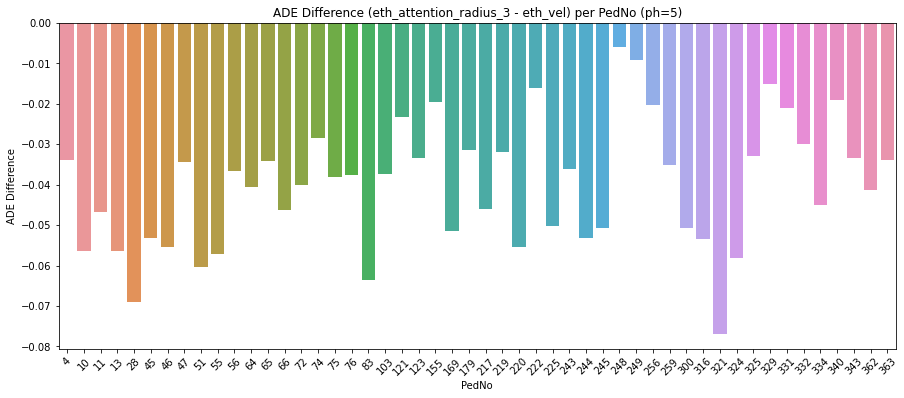

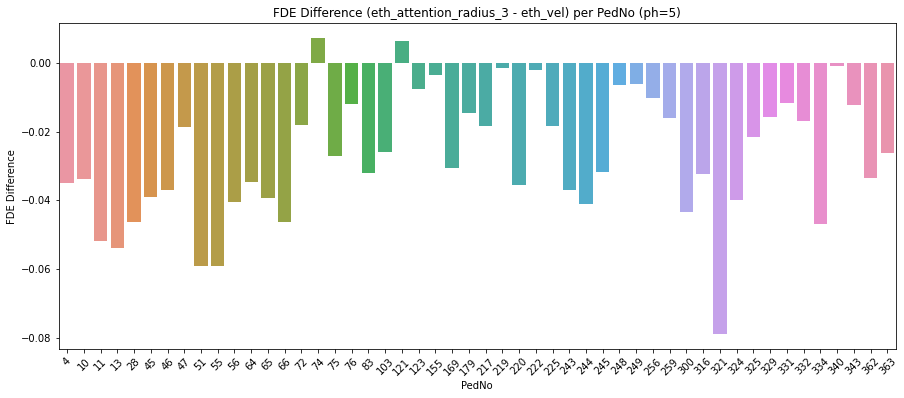

In [12]:
import seaborn as sns

file_path = '/home/sina/env_prediction_project/Trajectron-plus-plus/errors_log.csv'

df = pd.read_csv(file_path, header=None, 
                 names=['Model', 'Test Data', 'ph', 'PedNo', 'ADE', 'FDE'])

df_filtered = df[
    (df['Test Data'] == 'univ_test') &
    (df['Model'].isin(['eth_vel', 'eth_attention_radius_3'])) &
    (df['ph'] == 5)
]

# Pivot so that each PedNo has columns for each model's ADE
pivot_df_ADE = df_filtered.pivot(index='PedNo', columns='Model', values='ADE')
pivot_df_FDE = df_filtered.pivot(index='PedNo', columns='Model', values='FDE')

# Compute the difference (e.g., eth_attention_radius_3 minus eth_vel)
pivot_df_ADE['ADE_diff'] = pivot_df_ADE['eth_attention_radius_3'] - pivot_df_ADE['eth_vel']
pivot_df_FDE['FDE_diff'] = pivot_df_FDE['eth_attention_radius_3'] - pivot_df_FDE['eth_vel']

# Reset index for plotting
pivot_reset_ADE = pivot_df_ADE.reset_index()
pivot_reset_FDE = pivot_df_FDE.reset_index()

plt.figure(figsize=(15, 6))
sns.barplot(data=pivot_reset_ADE, x='PedNo', y='ADE_diff')
plt.title('ADE Difference (eth_attention_radius_3 - eth_vel) per PedNo (ph=5)')
plt.xlabel('PedNo')
plt.ylabel('ADE Difference')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(15, 6))
sns.barplot(data=pivot_reset_FDE, x='PedNo', y='FDE_diff')
plt.title('FDE Difference (eth_attention_radius_3 - eth_vel) per PedNo (ph=5)')
plt.xlabel('PedNo')
plt.ylabel('FDE Difference')
plt.xticks(rotation=45)
plt.show()

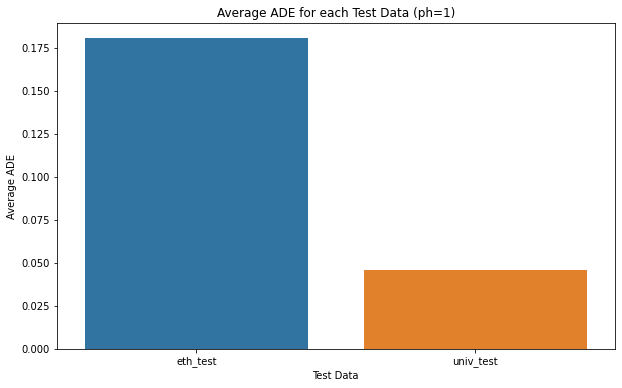

In [13]:
# Filter the dataframe for the required conditions
df_filtered = df[
    (df['Test Data'].isin(['univ_test', 'eth_test'])) &
    (df['Model'] == 'eth_attention_radius_3') &
    (df['ph'] == 1)
]

# Group by Test Data and calculate the average ADE
average_ade = df_filtered.groupby('Test Data')['ADE'].mean().reset_index()

# Plot the average ADE for each Test Data
plt.figure(figsize=(10, 6))
sns.barplot(data=average_ade, x='Test Data', y='ADE')
plt.title('Average ADE for each Test Data (ph=1)')
plt.xlabel('Test Data')
plt.ylabel('Average ADE')
plt.show()


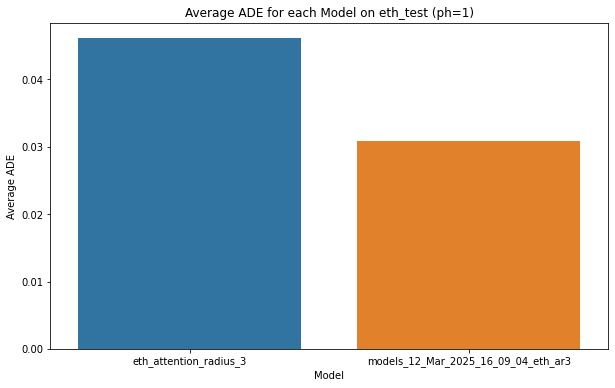

In [16]:
# Filter the dataframe for the required conditions
df_filtered = df[
    (df['Test Data'].isin(['univ_test'])) &
    (df['Model'].isin(['eth_attention_radius_3', 'models_12_Mar_2025_16_09_04_eth_ar3'])) &
    (df['ph'] == 1)
]

# Group by Test Data and calculate the average ADE
average_ade = df_filtered.groupby('Model')['ADE'].mean().reset_index()

# Plot the average ADE for each Test Data
plt.figure(figsize=(10, 6))
sns.barplot(data=average_ade, x='Model', y='ADE')
plt.title('Average ADE for each Model on eth_test (ph=1)')
plt.xlabel('Model')
plt.ylabel('Average ADE')
plt.show()


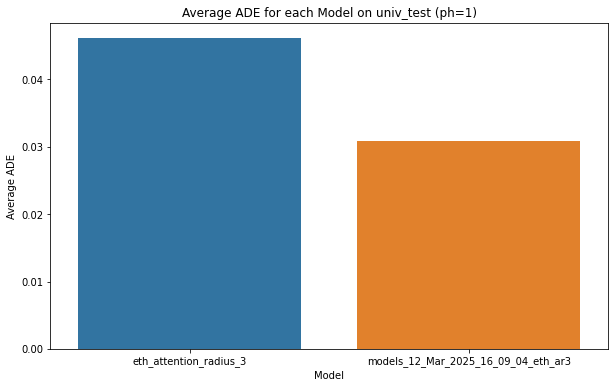

In [19]:
# Filter the dataframe for the required conditions
df_filtered = df[
    (df['Test Data'].isin(['univ_test'])) &
    (df['Model'].isin(['eth_attention_radius_3', 'models_12_Mar_2025_16_09_04_eth_ar3'])) &
    (df['ph'] == 1)
]

# Group by Test Data and calculate the average ADE
average_ade = df_filtered.groupby('Model')['ADE'].mean().reset_index()

# Plot the average ADE for each Test Data
plt.figure(figsize=(10, 6))
sns.barplot(data=average_ade, x='Model', y='ADE')
plt.title('Average ADE for each Model on univ_test (ph=1)')
plt.xlabel('Model')
plt.ylabel('Average ADE')
plt.show()

# TASKS
Difference of 30 and 100 models
fde for a specific number of pedestrians (not average), compare same pedestrias on two models

Mode!!! used for each prediction

Mode association

Configuration parameters from the JSON file as well as the parameters passed into the prediction function. In our codebase, the JSON configuration is loaded to set up the hyper‐parameters for the pedestrian model (see for example config.json) and the predict method is called on the loaded Trajectron instance (from trajectron.py).

─────────────────────────────
**Config.json parameters:**

• **batch_size (256):**  
  The number of training examples in a single batch.

• **grad_clip (1.0):**  
  The threshold for clipping gradients to prevent exploding gradients.

• **learning_rate_style ("exp"):**  
  Determines the type of learning rate schedule (here, an exponential decay).

• **learning_rate (0.001):**  
  The initial learning rate for training.

• **min_learning_rate (1e-05):**  
  The lower bound for the learning rate during decay.

• **learning_decay_rate (0.9999):**  
  The factor by which the learning rate is decreased at each update.

• **prediction_horizon (12):**  
  The number of timesteps into the future that the model predicts.

• **minimum_history_length (1) & maximum_history_length (7):**  
  The minimum and maximum number of past timesteps used as input.

• **map_encoder (for “PEDESTRIAN”):**  
  A nested set of hyper-parameters for encoding map information.  
   – **heading_state_index (6):** Index in the input state that encodes heading.  
   – **patch_size ([50, 10, 50, 90]):** Dimensions of patches extracted from the map.  
   – **map_channels (3):** Number of channels in the map input (e.g. RGB).  
   – **hidden_channels ([10, 20, 10, 1]):** The sizes of hidden layers in the map encoder.  
   – **output_size (32):** The final output dimension of the map encoding.  
   – **masks ([5, 5, 5, 5]) & strides ([1, 1, 1, 1]):** Convolutional parameters controlling receptive field and downsampling.  
   – **dropout (0.5):** Dropout rate applied in the map encoder.

• **k (1) and k_eval (25):**  
  ‘k’ may denote the number of latent samples used during training while ‘k_eval’ is the number of modes (or candidate predictions) the model considers during evaluation.

• **KL divergence parameters:**  
   – **kl_min (0.07):** Minimum value used for the KL term.  
   – **kl_weight (100.0):** Weight for the KL divergence in the loss.  
   – **kl_weight_start (0):** Starting weight for KL divergence scheduling.  
   – **kl_decay_rate (0.99995):** Rate at which the KL weight decays over iterations.  
   – **kl_crossover (400), kl_sigmoid_divisor (4):** Parameters to control the schedule (usually via a sigmoid) for the KL weight.

• **RNN/MLP dimensions and dropout:**  
   – **rnn_kwargs ({"dropout_keep_prob": 0.75}):** Arguments for RNNs (e.g. dropout probability).  
   – **MLP_dropout_keep_prob (0.9):** Dropout probability for MLP layers.  
   – **enc_rnn_dim_edge, enc_rnn_dim_edge_influence, enc_rnn_dim_history, enc_rnn_dim_future (all set to 32):** Hidden dimensions for various encoders.  
   – **dec_rnn_dim (128):** Dimensionality of the decoder’s hidden state.

• **MLP dimensions for latent variables:**  
   – **q_z_xy_MLP_dims:** (null here) would specify MLP dimensions for approximating the posterior over latent variables.  
   – **p_z_x_MLP_dims (32):** For the prior network.

• **GMM_components (1):**  
   Number of components in the Gaussian Mixture Model used to model the multimodality.

• **log_p_yt_xz_max (6):**  
   A cap on the log-likelihood values.

• **N (1) and K (25):**  
   These parameters are often used for sampling – where N is the number of samples drawn per instance during training and K (matching k_eval) denotes the number of prediction modes evaluated from the lattice.

• **τ (tau) parameters:**  
   – **tau_init (2.0):** Initial temperature for any annealing (for example, in softmax sampling).  
   – **tau_final (0.05):** Final temperature value.  
   – **tau_decay_rate (0.997):** Rate at which τ decays.

• **Latent logit clipping:**  
   – **use_z_logit_clipping (true):** A flag to enable clipping of latent logits.  
   – **z_logit_clip_start (0.05), z_logit_clip_final (5.0), z_logit_clip_crossover (300), z_logit_clip_divisor (5):** These control the range and schedule of clipping for numerical stability.

• **Dynamic model specification:**  
   – **dynamic (for “PEDESTRIAN”):** Here set to use a "SingleIntegrator" model without an explicit output distribution.  
  
• **State and prediction state definitions:**  
   – **state (for “PEDESTRIAN”):** Specifies which state components to track (position, velocity, acceleration – each with x and y components).  
   – **pred_state (for “PEDESTRIAN”):** In prediction, only velocity (x and y) is predicted.

• **Other parameters:**  
   – **log_histograms (false):** Whether to log activation histograms.  
   – **dynamic_edges ("yes"):** If pairwise interactions (edges) are dynamic.  
   – **edge_state_combine_method ("sum") & edge_influence_combine_method ("attention"):** Methods for fusing information from neighboring nodes.  
   – **edge_addition_filter ([0.25, 0.5, 0.75, 1.0]) and edge_removal_filter ([1.0, 0.0]):** Thresholds for adding/removing edge connections in the scene graph.  
   – **offline_scene_graph ("yes"):** Whether to compute the scene graph offline.  
   – **incl_robot_node (false):** Whether to include the robot/ego node.  
   – **node_freq_mult_train/eval, scene_freq_mult_train/eval/viz (all false):** Flags that may weight nodes or scenes differently.  
   – **edge_encoding (true):** Whether to encode edge attributes.  
   – **use_map_encoding (false):** Whether to include map encoding in the prediction.  
   – **augment (true):** If data augmentation is used during training.  
   – **override_attention_radius ([]):** Optional manual override for attention radii between node types.

─────────────────────────────
**Parameters passed to the predict function:**

The predict function is defined (typically) in the Trajectron class in trajectron.py and is used in both the “most likely z” branch and the “full” evaluation branch in evaluate.py. The parameters are as follows:

• **scene:**  
  An instance of a scene (from the nuScenes environment) on which the model should predict future trajectories. It supplies all observed data including history, sensor inputs, etc.

• **timesteps:**  
  An array (usually created via np.arange) representing the indices of timesteps in the scene. It tells the function from which frame(s) to start prediction.

• **ph (prediction horizon):**  
  A scalar (e.g. 12) indicating the number of future timesteps the model should predict. In our configuration, “prediction_horizon” is set to 12.

• **num_samples:**  
  The number of predictions (or samples) to draw from the model’s stochastic latent space.  
  – For example, in “Full” evaluation, we use 2000 samples to cover the output distribution.

• **min_future_timesteps (8):**  
  The minimum number of future timesteps that must be available in the ground-truth data for a prediction to be computed. This guards against scenes that are too short.

• **z_mode (Boolean):**  
  If set to True, the predict method returns the trajectory corresponding to the “most likely” latent variable (typically the mode of the latent distribution) rather than sampling multiple values.  
   – Used in the “GMM Z Mode (Most Likely)” branch.

• **gmm_mode (Boolean):**  
  If True, the prediction is produced using the Gaussian Mixture Model formulation (the model outputs multiple modes along with their probabilities). This flag toggles which parts of the code are used when evaluating the prediction likelihood.
   – In “GMM Z Mode,” this is set to True.

• **full_dist (Boolean):**  
  When True, the function returns the full distribution over possible future trajectories (for example, to later compute negative log likelihoods or other uncertainty metrics).  
   – In our evaluation code, we set this to False so that only the predicted trajectories (and not the full distribution) are returned.

─────────────────────────────
**Usage in code:**  
– The **predict** call can be found in evaluate.py (see lines 134–141 for one branch and later in the “Full” evaluation branch). It is used by the Trajectron instance (returned via load_model) to produce predictions given a scene and time settings.  
– The **config parameters** are later used in functions that build the model (in Trajectron and ModelRegistrar), in setting annealing parameters (via set_annealing_params), and to define the scene graph and state definitions used during prediction and evaluation.

This detailed breakdown shows both what each hyper‐parameter controls and where the prediction options (such as sampling count and mode selection) are set for the evaluation process.